In [1]:
import scipy.sparse as sparse
import scipy.linalg as linalg
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import mylib

$$ \frac{d}{dx}\left(\nu\frac{du}{dx}\right) + \alpha\,u = f\qquad x\in\,(0,L)\qquad\alpha\in\mathbb{R}$$

cond(A) = 33283.446632716725
monolithic error = 7.336539011380924e-12
{'type': 'dirichlet', 'value': 0.1881772468829075}
{'type': 'dirichlet', 'value': -1.28088441661129}


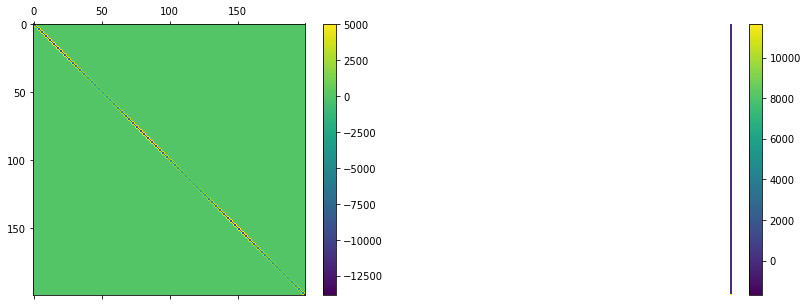

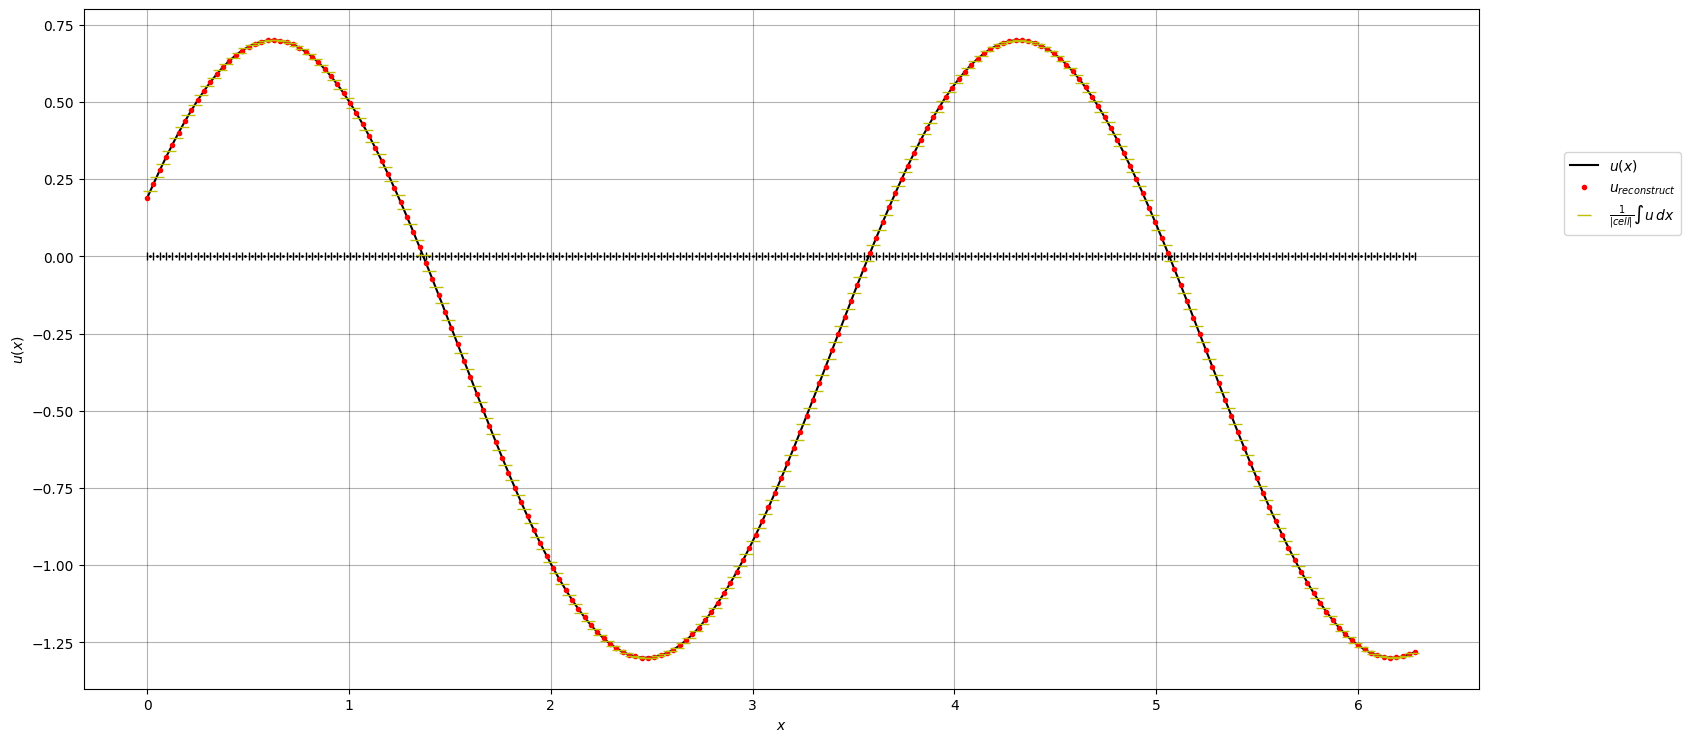

In [5]:
kwargs = {
    'A': -0.3,
    'B': 1.0,
    'C': 1.7,
    'D': -0.3,
    'E': 3.0,
    'F': 2.0,
    'G': 3.0,
    'H': 0.0
}

L = 2*np.pi
N = 200
dx = np.divide(L, N)
x = np.linspace(0, L, N+1)
xc = np.linspace(0.5*dx, L-0.5*dx, N)
xfine = np.linspace(0, L, 1000)

def alpha(x, kwargs):
    return 10.0 + 0.5*np.sin(4.0*x)

def sol(x, kwargs):
    return kwargs['A'] + kwargs['B']*np.sin(kwargs['C']*(x-kwargs['D']))

def dsoldx(x, kwargs):
    return kwargs['B']*kwargs['C']*np.cos(kwargs['C']*(x-kwargs['D']))

def d2soldx2(x, kwargs):
    return -kwargs['B']*np.square(kwargs['C'])*np.sin(kwargs['C']*(x-kwargs['D']))

def nu(x, kwargs):
    return kwargs['E'] + kwargs['F']*np.sin(kwargs['G']*(x-kwargs['H']))

def dnudx(x, kwargs):
    return kwargs['F']*kwargs['G']*np.cos(kwargs['G']*(x-kwargs['H']))
   
def f(x, kwargs):
    return alpha(x, kwargs)*sol(x, kwargs) + nu(x, kwargs)*d2soldx2(x, kwargs) + dnudx(x, kwargs)*dsoldx(x, kwargs)
    
leftBC = {
    'type':'dirichlet',
    'value':sol(0.0, kwargs)}

rightBC = {
    'type':'dirichlet', #'type':'neumann',
    'value':sol(L, kwargs)}

A_laplacian, fBC = mylib.fvm_laplacian_1D(nu, leftBC, rightBC, N, dx, L, kwargs)
fTOT = f(xc, kwargs) + fBC

A = A_laplacian + sparse.diags([alpha(xc, kwargs)], [0])
A = A.toarray()

u = linalg.solve(A, fTOT)

print("cond(A) =", np.linalg.cond(A))
print(f"monolithic error = {np.linalg.norm(fTOT-np.dot(A,u))}")
print(leftBC)
print(rightBC)

fig1, axs = plt.subplots(1, 2, figsize=(14,5))
axsA = axs[0].matshow(A)
axsf = axs[1].matshow(fTOT.reshape((N,1)))
fig1.colorbar(axsA, ax=axs[0])
fig1.colorbar(axsf, ax=axs[1])
axs[1].axis('off')
#plt.savefig('figures/matrix.pdf')

fig, ax1 = plt.subplots(figsize=(18,9), dpi=100)
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$u(x)$')
ax1.plot(x, 0*x, '|', color='k', markersize=6.0)
ax1.plot(xc, 0*xc, '.', color='k', markersize=2.0)
ax1.plot(xfine, sol(xfine, kwargs), '-k', label=r'$u(x)$')
ax1.plot(x, mylib.fvm_reconstruct_1D(u), '.r' , label=r'$u_{reconstruct}$', linewidth=0.8)
ax1.plot(xc, u, '_y', label=r'$\frac{1}{|cell|}\int u\,dx$', markersize=10)
#ax.set_ylim(bottom=0.0)
#ax.set_xlim([-0.001,0.1])
ax1.legend(bbox_to_anchor=(1.15, 0.8))
ax1.grid(color='k', alpha=0.3)

# ax2 = ax1.twinx()
# ax2.plot(xfine, f(xfine, kwargs), '--k', label=r'$f(x)$', linewidth=0.8)
# ax2.plot(xfine, nu(xfine, kwargs), '--r', label=r'$\nu(x)$', linewidth=0.8)
# ax2.plot(xfine, alpha(xfine, kwargs), '--g', label=r'$\alpha(x)$', linewidth=0.8)
# ax2.set_ylabel(r'$f(x), \nu(x)$', color='r')
# ax2.tick_params(axis='y', colors='red')
# ax2.legend(bbox_to_anchor=(1.15, 0.6))
# ax2.grid(color='r', alpha=0.3)

plt.plot()
plt.show()